In [48]:
import sys
import math
import numpy as np
import json
sys.path.insert(0, '..')
from net_framework import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

## Analyzing json Data

In [51]:
num_langs = 3
node_num = range(1,25)

In [73]:
files = []
for i in range(20, 34):
    with open('validation_errors_{0}.json'.format(i+1)) as f:
        output_file=json.load(f)
    files.append(output_file)

In [77]:
experiment_complexities = []
for i in range(14):
    print(i)
    output_file = files[i]
    errors = []
    for size in node_num:
        out_dict_for_size = output_file[str(size)]
        vals = list(out_dict_for_size.values())
        vals = np.array(vals)
        vals = vals[:,0]
        errors.append(np.min(vals))
    errors = np.array(errors)

    thresholds = np.arange(.001, 1, .001)

    min_sizes = []
    for threshold in thresholds:
        idx = 0
        for err in errors:
            if err <= threshold:
                break
            idx += 1
        if idx < len(node_num):
            min_sizes.append(node_num[idx])
        else:
            min_sizes.append(max(node_num))

    complexity = np.mean(min_sizes)
    experiment_complexities.append(complexity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13


## Calculating Information Complexities

### Formatting Data

In [78]:
term_data = pd.read_csv('term.txt', sep="\t", header=None)
term_data.columns = ["#Lnum", "#snum", "#cnum", "Term Abbrev"]
term_data.head()
cnum_data = pd.read_csv('cnum-vhcm-lab-new.txt', sep="\t")
cnum_coordinates = []
for i in range(len(cnum_data) + 1):
    target_row = cnum_data[cnum_data["#cnum"] == i]
    coordinate = target_row["L*"].tolist() + target_row["a*"].tolist() + target_row["b*"].tolist()
    a = target_row["a*"].tolist()
    b = target_row["b*"].tolist()
    cnum_coordinates.append(coordinate)
print(cnum_data)
print(cnum_coordinates)

     #cnum  V   H  C     MunH  MunV     L*     a*     b*
0      141  A   0  0  10.00RP   9.5  96.00  -0.06   0.06
1      274  B   0  0  10.00RP   9.0  91.08  -0.05   0.06
2      129  B   1  2    2.50R   9.0  91.08   5.53   2.22
3      230  B   2  2    5.00R   9.0  91.08   5.51   3.28
4      302  B   3  2    7.50R   9.0  91.08   5.54   4.46
..     ... ..  .. ..      ...   ...    ...    ...    ...
325    305  I  37  8   2.50RP   2.0  20.54  34.44 -14.69
326    267  I  38  8   5.00RP   2.0  20.54  35.44 -10.40
327    243  I  39  8   7.50RP   2.0  20.54  35.97  -6.33
328    182  I  40  8  10.00RP   2.0  20.54  36.42  -2.08
329     89  J   0  0  10.00RP   1.5  15.60  -0.02   0.02

[330 rows x 9 columns]
[[], [61.7, -4.52, -39.18], [81.35, -19.64, -4.3], [51.57, 55.2, 68.32], [20.54, 24.14, -14.33], [81.35, -33.04, 4.96], [81.35, 14.87, 30.96], [61.7, -46.97, 64.65], [30.77, 47.63, 5.24], [41.22, 22.15, 41.13], [20.54, 7.63, -35.92], [20.54, -16.13, -4.67], [81.35, -10.94, 87.9], [20.54, -27

### Information complexities

In [79]:

def language_complexity(lnum):
    language_data = term_data[term_data.get('#Lnum').eq(lnum)]
    unique_terms = list(language_data['Term Abbrev'].unique())
    l1_grouped = language_data.groupby('#cnum')['Term Abbrev'].apply(list)

    l1_chip_abbrev_percentage = [[(l1_grouped[i + 1].count(abbrev) / len(l1_grouped[i + 1])) \
                              for abbrev in unique_terms] for i in range(len(l1_grouped))]
    l1_result = pd.DataFrame(l1_chip_abbrev_percentage)
    l1_result.index += 1
    l1_result.index.name = '#cnum'
    l1_result.columns = unique_terms

    terms = unique_terms
    chips = list(language_data['#cnum'].unique())
    priors = [prior(j) for j in range(1, len(chips) + 1)]
    priors_sum = np.sum(priors, dtype = np.float64)
    complexity = 0
    for w in terms:
        word_prob = 0
        for m in chips:
            p_chip = priors[m-1] / priors_sum
            word_prob += p_chip * l1_result.at[m, w]
        for m in chips:
            p_chip = priors[m-1] / priors_sum
            encoder_prob = l1_result.at[m, w]
            if encoder_prob != 0:
                mutual_information = p_chip * encoder_prob * np.log2(encoder_prob / word_prob)
            complexity += mutual_information
    return complexity

variance = 64

def prior(cnum):
    coordinates = cnum_coordinates[cnum]
    l0 = coordinates[0]
    a0 = coordinates[1]
    b0 = coordinates[2]
    prob = 0
    for i in range(1, len(cnum_coordinates)):
        l = cnum_coordinates[i][0]
        a = cnum_coordinates[i][1]
        b = cnum_coordinates[i][2]
        sum1 = np.sum([np.power(l-l0, 2), np.power(a-a0, 2), np.power(b-b0, 2)], dtype=np.float64)
        dist = np.sqrt(sum1)
        pdf = np.exp(-(1/(2 * variance)) * dist)
        prob += pdf
    return prob
    
print(language_complexity(2))

6.23976681443679


In [69]:
information_complexities = []
for i in range(110):
    information_complexities.append(language_complexity(i+1))
print(information_complexities)

[3.0265579937043716, 6.23976681443679, 17.087169429193338, 5.52399983822609, 9.853596803958979, 10.390813692347013, 11.220648526449198, 6.067241381298623, 4.188913425282828, 4.589481615725248, 4.266736903962221, 3.6640800219305882, 8.00338592767426, 6.703549462184366, 4.920314737442471, 4.637841654733329, 11.258835720420535, 2.7891696815644464, 14.567304171588209, 13.631412468890854, 4.520182824305332, 3.8952777338741353, 1.8510934594986372, 10.690356147521745, 10.092256368349114, 5.168097390506066, 15.988674488727463, 7.016371679716365, 5.699519821826298, 3.8796560675623555, 3.4236777491058574, 6.628989014987687, 8.865022350043862, 5.975552588950229, 7.040873511380496, 3.199477998664945, 5.069080661200971, 5.193850464673266, 5.449277918888928, 4.3415444306754205, 6.013780196401241, 8.496909433954, 6.56196421895853, 17.184714919377324, 12.648450035551676, 9.758820652345115, 13.94838013425325, 6.106496791329174, 1.8016454824275772, 6.491363075780963, 18.786563575136952, 9.45349956963664

## Scatter Plotting Both Complexities

Text(0, 0.5, 'Estimated Complexity (arb. units)')

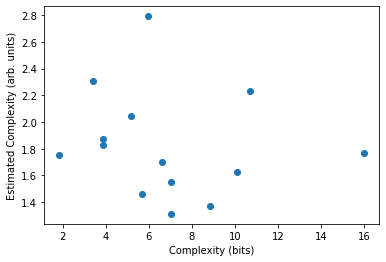

In [80]:
info_complexities = information_complexities[21:35]
plt.scatter(np.array(info_complexities), np.array(experiment_complexities))
plt.xlabel('Complexity (bits)')
plt.ylabel('Estimated Complexity (arb. units)')
